In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from utils import data_processing

%reload_ext autoreload
%autoreload 2

# Exploration

- Looking at the Lee Sin performance of player from the major regions. Lee is considered one of the most skilled champions in League of Legend so we want to take a closed look at the player performance on this hero.

- Note that observations form MSI and WCS regions contain data from wildcard regions.

- We are droping some irrelevant columns, some can be brought back like split/playoffs.

- Also there is alot of non existing columns due to lack of access such as dragon data. (THIS CAN BE POTTENTIALY ADDED SINCE ITS STORED IN TEAM RECORD)

In [2]:
# tournaments to evaluate
major_regions = ['LPL', 'LCK', 'LEC', 'LCS', 'MSI', 'WCS', 'NA LCS', 'EU LCS', 'KeSPA']
# droping columns that i find no use for at least for now
drop_irrelevant = [
    'gameid', 'datacompleteness', 'url', 'split', 'playoffs', 
    'date', 'game', 'patch', 'participantid', 'position', 
    'playerid', 'teamname', 'teamid', 'champion', 'ban1', 
    'ban2', 'ban3', 'ban4', 'ban5', ]

# problematic columns, i think some of them can be added from column 'pos' == 'team' 
# but still there is problem with relevant LPL statistics 
drop_large_nulls = [
    'firstdragon', 'dragons', 'opp_dragons', 'elementaldrakes', 
    'opp_elementaldrakes', 'infernals', 'mountains', 'clouds', 
    'oceans', 'chemtechs', 'hextechs', 'dragons (type unknown)', 
    'elders', 'opp_elders', 'firstherald', 'heralds', 
    'opp_heralds', 'firstbaron', 'inhibitors', 'opp_inhibitors',
    'firsttower', 'towers', 'opp_towers', 'firstmidtower', 'firsttothreetowers', 'turretplates', 'opp_turretplates', 'gspd']

# interesting game start to evaluate
game_stats = ['kills', 'deaths', 'assists', 'dpm', 'damageshare', 'wardsplaced', 'wardskilled', 'minionkills', 'monsterkillsownjungle', 'monsterkillsenemyjungle']

df = data_processing.prepare_data_leesin(major_regions, drop_irrelevant, drop_large_nulls)
# time binning
bins = [60*x for x in [0,  25, 30, 35, 40, 45]]
bins.append(np.inf)
labels = ['<25', '25-30', '30-35', '35-40', '40-45', '>45']

df = df.assign(game_length_bins=lambda x: pd.cut(x['gamelength'], bins, labels=labels))

/home/quak/development/lol_stats/src/utils/data_processing.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + file_name)


## Player results

Lets take a look at number of victories, games played and winratio of individual playesr

In [3]:
result_by_player = (
    df
    .groupby(['playername'])
    .agg(
        wins = pd.NamedAgg('result', 'sum'),
        games_played = pd.NamedAgg('result', 'count'),
        win_ratio = pd.NamedAgg('result', lambda x: round(x.sum()/x.count()*100, 2)),
    )
    .sort_values(['games_played', 'wins'], ascending=[False, False])
)
one_game_players = len(result_by_player[result_by_player['games_played'] == 1])
atleast10_game_players = len(result_by_player[result_by_player['games_played'] >= 10])

print(f'Data collected for {len(result_by_player)} players')
print(f'No of players who played only single game as Lee Sin: {one_game_players}')
print(f'No of players who played more than 10 games as Lee Sin: {atleast10_game_players}')

Data collected for 219 players
No of players who played only single game as Lee Sin: 50
No of players who played more than 10 games as Lee Sin: 84


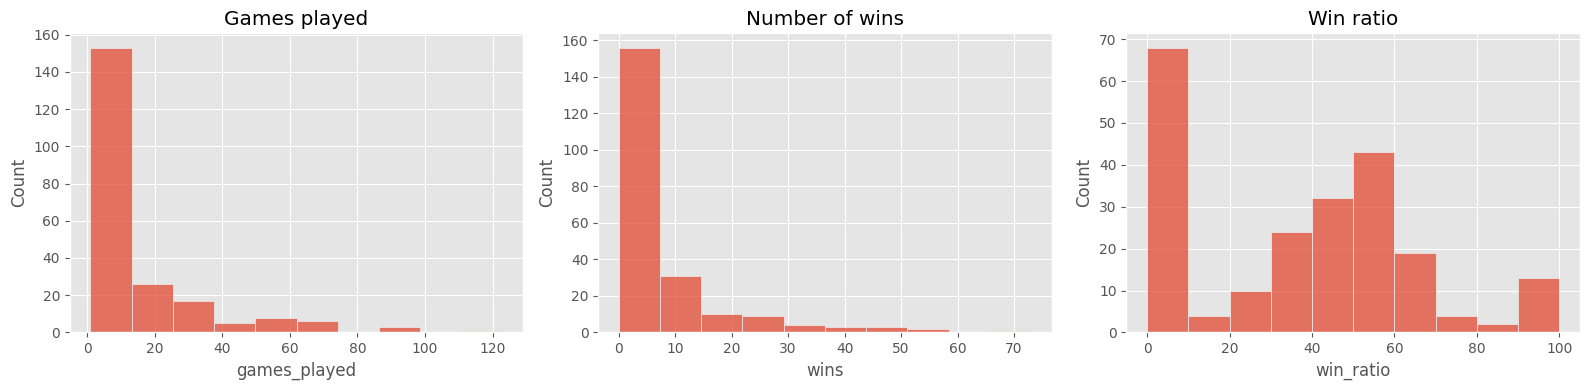

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.histplot(result_by_player, x='games_played', bins=10, ax=ax[0]), ax[0].set_title('Games played')
sns.histplot(result_by_player, x='wins', bins=10, ax=ax[1]), ax[1].set_title('Number of wins')
sns.histplot(result_by_player, x='win_ratio', bins=10, ax=ax[2]), ax[2].set_title('Win ratio')
fig.tight_layout()

- 1/4 of players played only a single game, lets check how many of them won their games.

- Only 12 out of 50 player won their only game, this could be described as the aspect of player mentality, because they failed to perform on such a difficult champion they decided to not try again

- This phenomena can also be found when we take a look at the players who played less than 10 games on Lee Sin, we are looking at over 400 games and only 124 were won.

In [5]:
wins_le10 = result_by_player[result_by_player['games_played'] < 10]['wins'].sum()
total_le10 = result_by_player[result_by_player['games_played'] < 10]['games_played'].sum()
wins_le10, total_le10

(124, 407)

## Possible best players

- Lets take a closer look at how high number of games played relate to the winrate of players

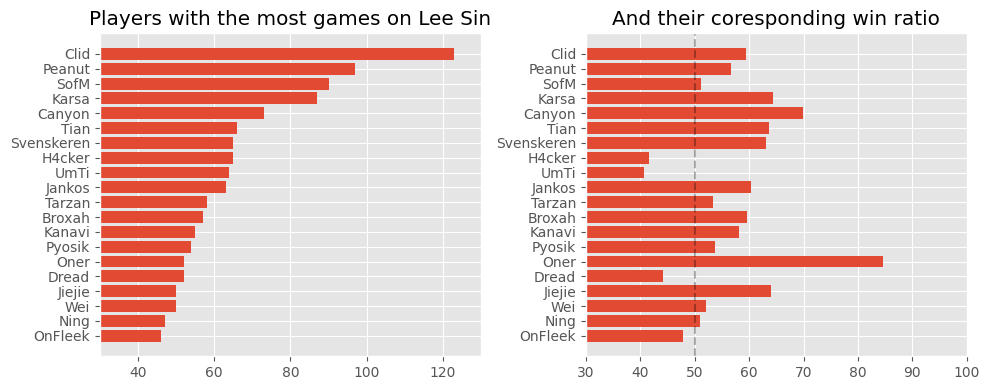

In [6]:
top20_games = (
    result_by_player
    .sort_values(by=['games_played']).tail(20)
)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].barh(top20_games.index, top20_games['games_played'])
ax[0].set_title('Players with the most games on Lee Sin'), ax[0].set_xlim(30, 130)

ax[1].barh(top20_games.index, top20_games['win_ratio']), ax[1].axvline(50, color='k', alpha=.3, linestyle='--')
ax[1].set_title('And their coresponding win ratio'), ax[1].set_xlim(30, 100)

fig.tight_layout()

- Most of these players are either Korean or Chineese players, with the exception of european players Svenskeren, Jankos and Broxah. As Asian players are considered much greatly mechanicaly gifted this is an expected result, but also prior to 2023 matches in Asian leagues were played in bo3/bo5 format in comaprison to Western regions so the sample is slightly biased towards them.
- Winratios of many of these players is around 50%, and we have even H4cker and UmTi with 40% winratios. But there are also exceptional results like Oner, exceptional rookie player aquired by T1, so lets look closer at such players with alot of games and high winrates

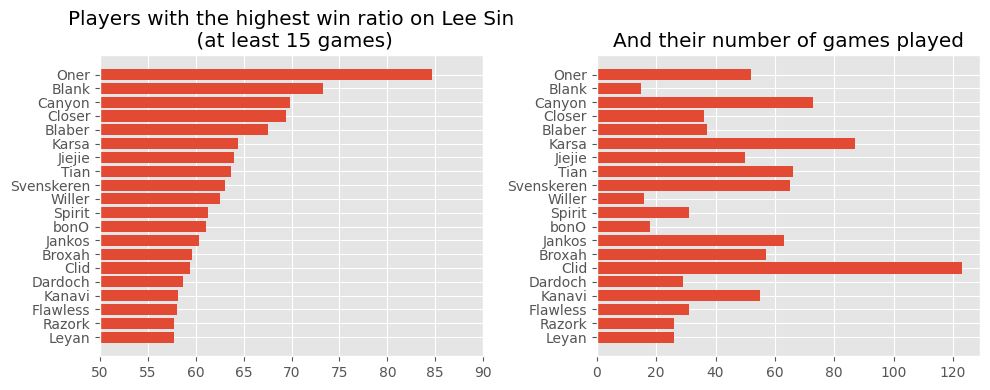

In [7]:
top20_wr = (
    result_by_player
    [result_by_player['games_played']  >= 15]
    .sort_values(by=['win_ratio']).tail(20)
)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].barh(top20_wr.index, top20_wr['win_ratio']) 
ax[0].set_title('Players with the highest win ratio on Lee Sin\n (at least 15 games)'), ax[0].set_xlim(50, 90)

ax[1].barh(top20_wr.index, top20_wr['games_played'])
ax[1].set_title('And their number of games played')

fig.tight_layout()

- Much greater number of European and American players in this section, including Closer, Blaber, Dardoch and Razork!
- Oner, Blank, Canyon, Karsa, Jiejie, Tian, Clid and Kanavi are the well known Asian junglers, 3 of them (Canyon, Blank, Jiejie, Tian) being previous world champions, while the rest of them were many time so close from holding the title.
- Definetly interesting to see Blank on this list. He played for a long time on T1, having many successful seasons, but definetly I do not remember him for his Lee Sin performance as opposed to Canyon and Tian.

## Results by year

Meta in league changes almost every month, champion get stronger or weeker and their popularity may decrese. Let's check the results in particular years and incoroprate the effect of the **side** champion was played on

In [8]:
yearly_results = (
    df
    .groupby(['year'])
    .agg(
        wins = pd.NamedAgg('result', 'sum'),
        games_played = pd.NamedAgg('result', 'count'),
        win_ratio = pd.NamedAgg('result', lambda x: round(x.sum()/x.count()*100, 2)),
    )
)
yearly_results.head()

,wins,games_played,win_ratio
year,,,
2015,48,108,44.44
2016,90,172,52.33
2017,313,623,50.24
2018,45,108,41.67
2019,210,420,50.00


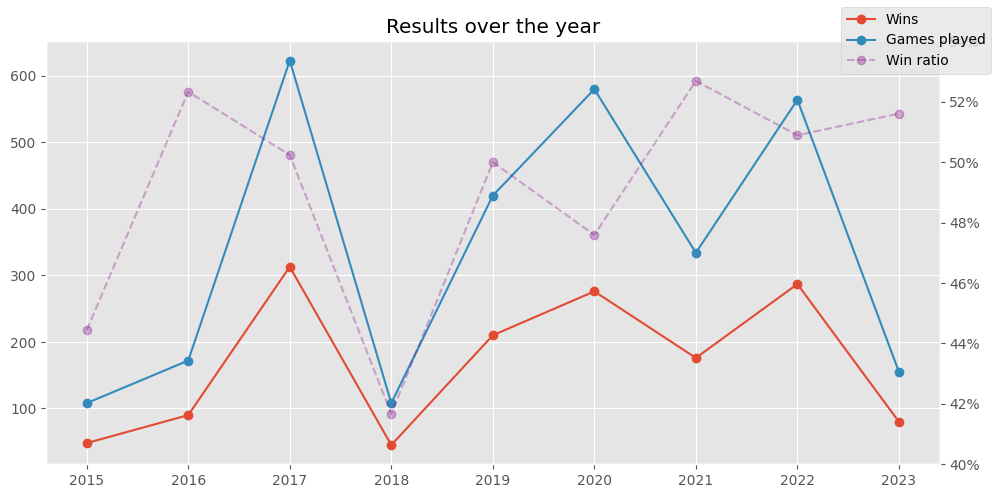

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax2 = ax.twinx()
ax.plot(yearly_results.index, yearly_results['wins'], 'o-')
ax.plot(yearly_results.index, yearly_results['games_played'], 'o-')
ax2.plot(yearly_results.index, yearly_results['win_ratio'], 'o--',color='purple', alpha=.3)
# styles
ax2.set_yticks(plt.yticks()[0], [f'{int(x)}%' for x in plt.yticks()[0]])
fig.legend(['Wins', 'Games played', 'Win ratio']), ax.set_title('Results over the year')
ax2.grid(False)
fig.tight_layout()

- As we can see years the the Lee's winrate was the lowest was in 2015 and 2018, where many different characters were dominating the jungle at that time. It could be that low winrate at the beggining of the season resulted in people choosing not to pick him as he was outperformed by other junglers (but this is not the point of this analysis). 
- In the rest of the seasons his winrate oscilates around 50% (possibly we could also add aggregated count of lee bans to show in which season he was trully dominant champion)

### Exploring winratio by side selection

- Element of side selection is definetly an important factor, it impacts early jungle pathing, and possible snowball resulting from this can hardly increase chance of victory for Lee Sin
- As we can see, lee is definetly picked more often on red side, but he wins more games when on blue side $54 \%$

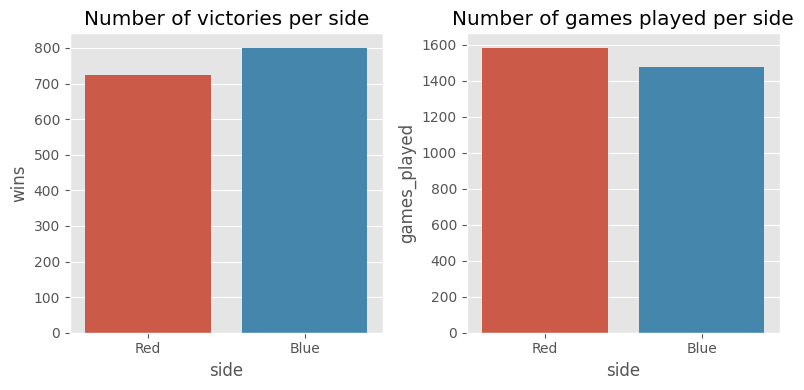

In [10]:
win_side = (
    df
    .groupby(['side'])
    .agg(
        wins = pd.NamedAgg('result', 'sum'),
        games_played = pd.NamedAgg('result', 'count'),
        win_ratio = pd.NamedAgg('result', lambda x: round(x.sum()/x.count()*100, 2)),
    )
    .reset_index()
    .sort_values(by='side', ascending=False)
)
win_side
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.barplot(win_side, x='side', y='wins', ax=ax[0])
sns.barplot(win_side, x='side', y='games_played', ax=ax[1])
ax[0].set_title('Number of victories per side')
ax[1].set_title('Number of games played per side')
fig.tight_layout()

- There is definetly alot of going on when we search side winrate depending on league, in general this trend of blue side Lee sin holds

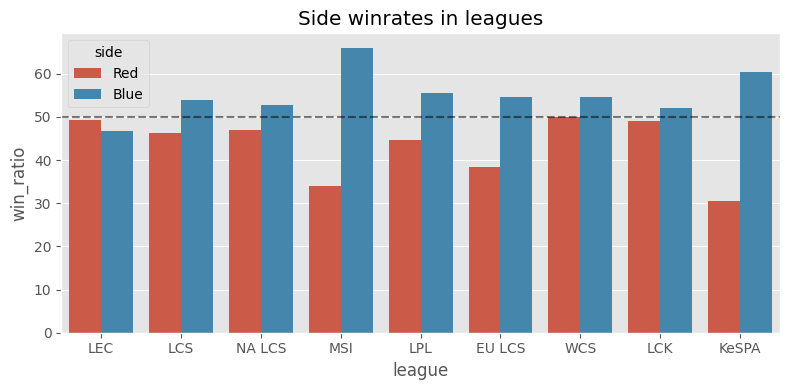

In [11]:
wins = (
    df
    .groupby(['league','side'])
    .agg(
        wins = pd.NamedAgg('result', 'sum'),
        games_played = pd.NamedAgg('result', 'count'),
        win_ratio = pd.NamedAgg('result', lambda x: round(x.sum()/x.count()*100, 2)),
    )
    .sort_values(['league','side', 'win_ratio'])
    .reset_index().sort_values(by='side', ascending=False)
)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.barplot(wins, x='league', y='win_ratio', hue='side', ax=ax)
ax.axhline(50, color='k', linestyle='--', alpha=.5)
ax.set_title('Side winrates in leagues')
fig.tight_layout()

## Game length and related gameplay stats

- We will inspect now the relation between length of the game and common statistics describing player performance at the end of the game.
- League games can span from 15 to 60 minutes, games that end before 25 minuts are considered one sided stomps, while games above 45 minutes can be considered as games in a late stage
- Also to further analyse this data we can consider binning it into 6 categories (separated by black lines on chart), as one of the main game objectives dragon spawn every 5 minutes, which we can consider as deepening game states.

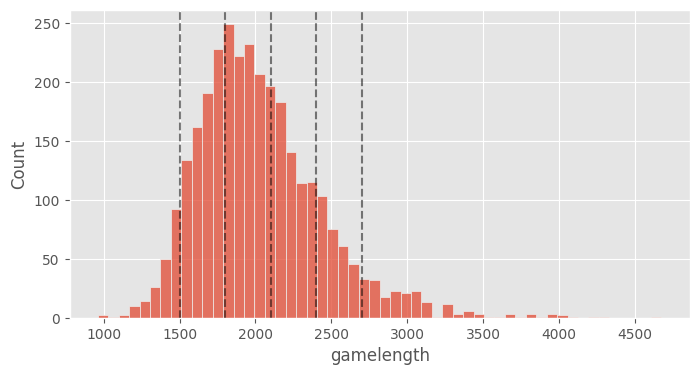

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(df, x='gamelength')
for x in [25, 30, 35, 40, 45]:
    ax.axvline(x=60*x, color='k', linestyle='--', alpha=.5)

In [13]:
gamelength_wr = (
    df
    .groupby('game_length_bins')
    .agg(
        wins = pd.NamedAgg('result', 'sum'),
        games_played = pd.NamedAgg('result', 'count'),
        win_ratio = pd.NamedAgg('result', lambda x: round(x.sum()/x.count()*100, 2)),
    )
    .reset_index()
)

- Winratio in specified gamelengths

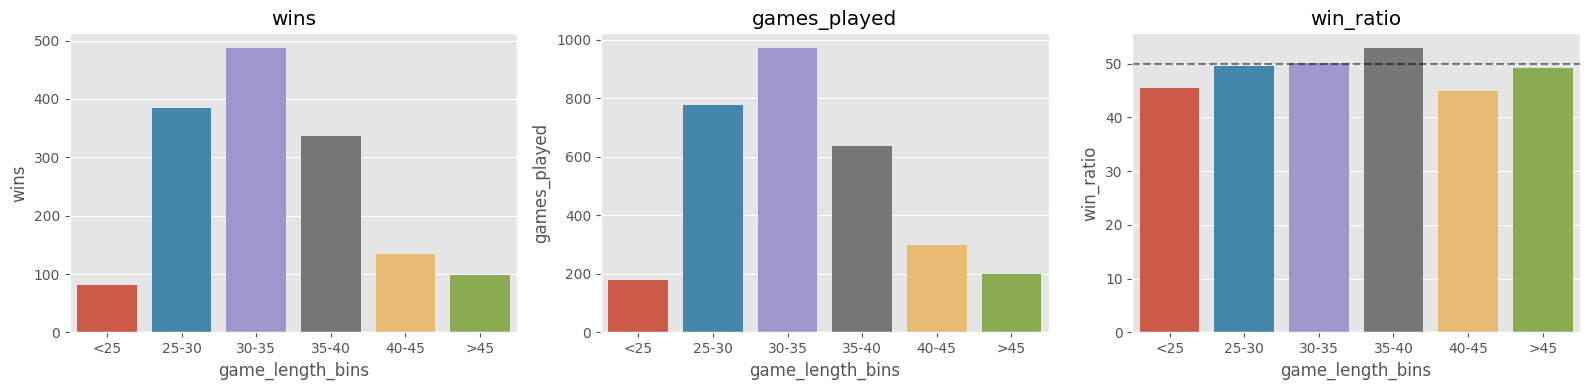

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for x, ax in zip(gamelength_wr.columns[1:], axs):
    sns.barplot(gamelength_wr, x='game_length_bins', y=x,  ax=ax)
    ax.set_title(x)
axs[2].axhline(50, color='k', linestyle='--', alpha=.5)
fig.tight_layout()

- We can also take a look at post game player statistics

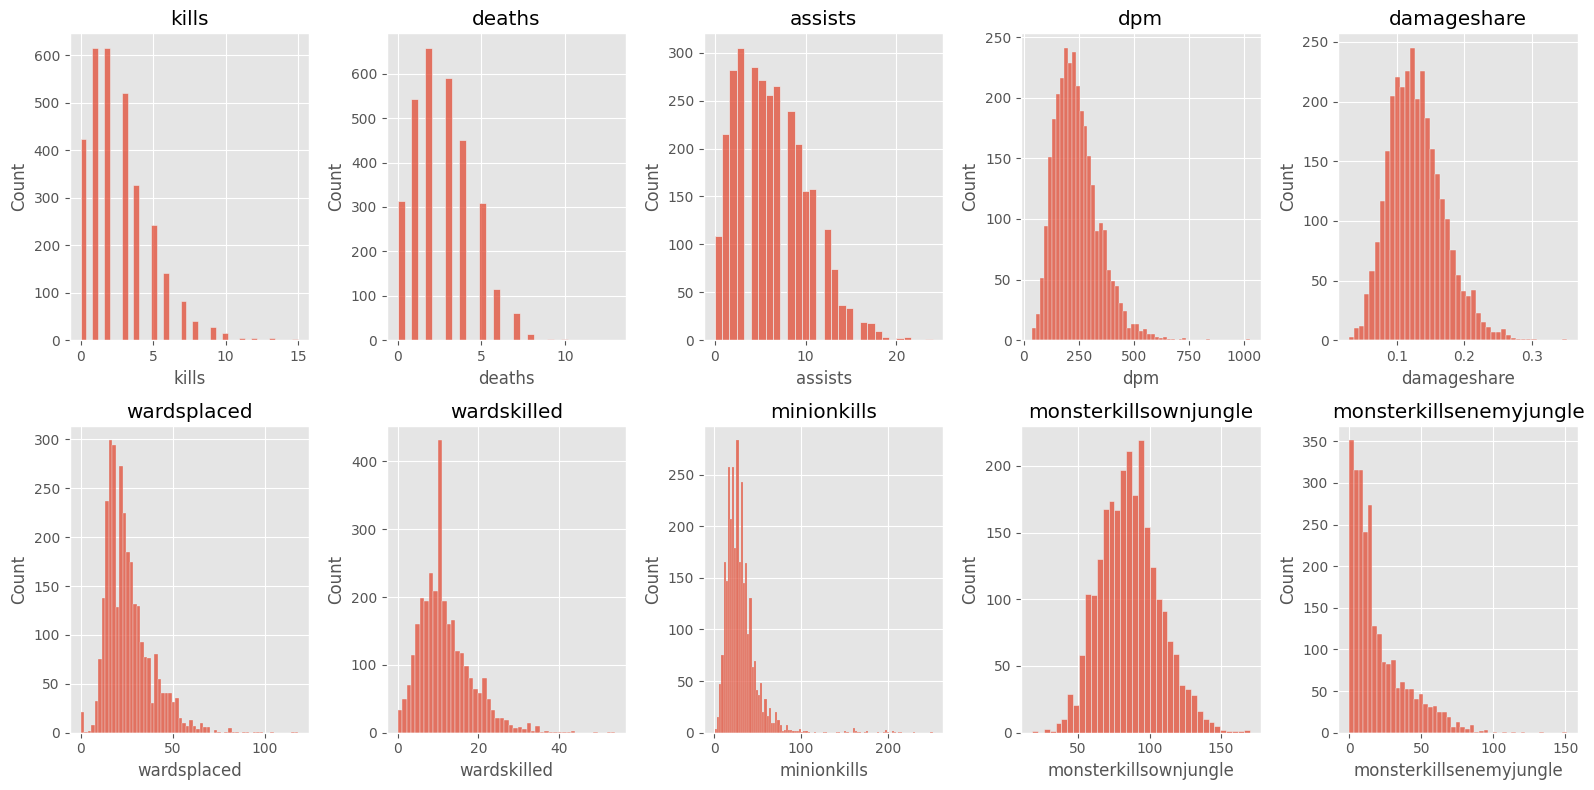

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.ravel()
for idx, val in enumerate(game_stats):
    sns.histplot(df, x=val, ax=ax[idx])
    ax[idx].set_title(val)

fig.tight_layout()

- Lets visualize KDE of these distributions stratified by the game length
- Kills and deaths are almost the same distributions across teh time
- As time goes on Lee players gain more assists, their dmgshare lowers as carries start to gain more level and items
- Rest of the statistics show natural movement of mean toward higher values and their variance increases with time

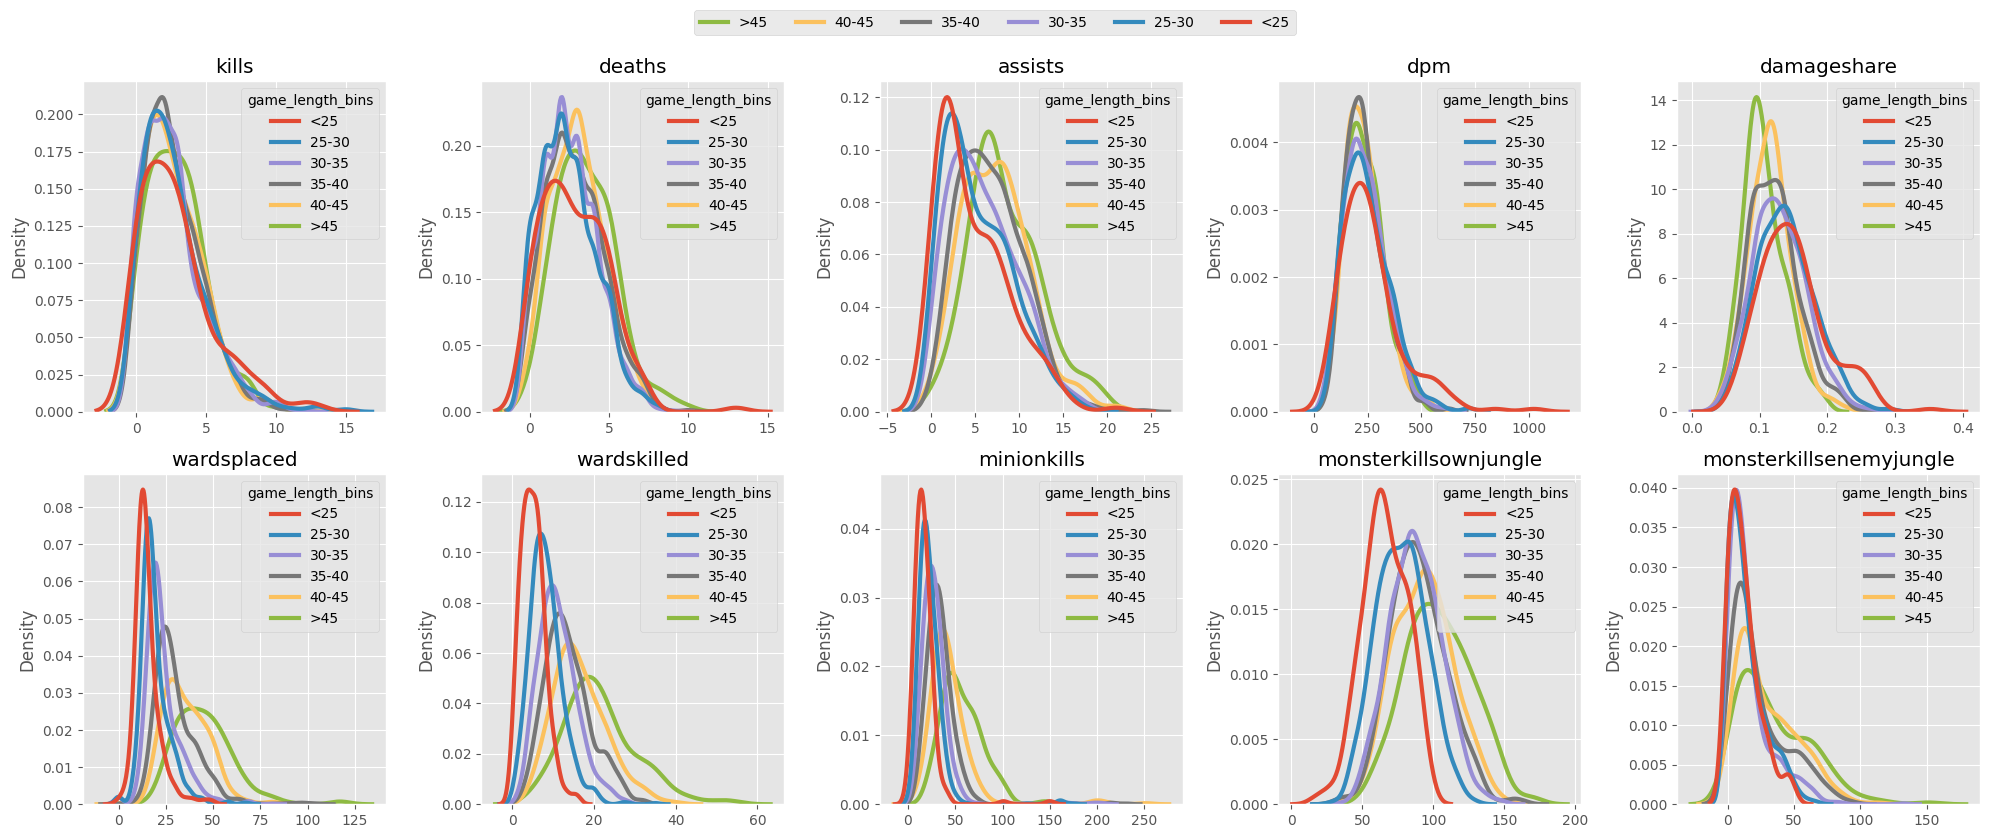

In [16]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
ax = ax.ravel()
for idx, val in enumerate(game_stats):
    sns.kdeplot(df, x=val, hue='game_length_bins', ax=ax[idx], linewidth=3, common_norm=False)
    ax[idx].set_title(val), ax[idx].set_xlabel(''), 
    # ax[idx].legend([])

fig.legend([x for x in reversed(labels)], loc='upper center', ncols=6, bbox_to_anchor=(0, 1.05, 1, 0))
fig.tight_layout()

In [17]:
with pd.option_context('display.max_columns', None):
    display(df.head())

,league,year,side,playername,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,doublekills,triplekills,quadrakills,pentakills,firstblood,firstbloodkill,firstbloodassist,firstbloodvictim,team kpm,ckpm,barons,opp_barons,damagetochampions,dpm,damageshare,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,earnedgoldshare,goldspent,total cs,minionkills,monsterkills,monsterkillsownjungle,monsterkillsenemyjungle,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15,game_length_bins
0,EU LCS,2015,Red,Jankos,2351,0,2,2,2,4,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1021,0.5104,NaN,NaN,8467.0,216.0868,0.163046,760.0681,0.0,33.0,0.8422,3.0,0.0766,4.0,0.0,0.0,10012.0,5241.0,133.7558,0.190367,9505.0,116.0,28.0,88.0,88.0,0.0,2.9604,2764.0,2958.0,38.0,2895.0,2901.0,39.0,-131.0,57.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,4212.0,4582.0,54.0,4999.0,4878.0,54.0,-787.0,-296.0,0.0,0.0,1.0,1.0,2.0,2.0,1.0,35-40
1,EU LCS,2015,Blue,Diamondprox,1577,0,0,5,0,7,18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2663,0.9512,NaN,NaN,2430.0,92.4540,0.068184,636.9436,0.0,21.0,0.7990,2.0,0.0761,3.0,0.0,0.0,5656.0,2356.0,89.6386,0.117859,5160.0,65.0,15.0,50.0,46.0,4.0,2.4731,2432.0,2494.0,31.0,2854.0,2955.0,36.0,-422.0,-461.0,-5.0,0.0,0.0,0.0,0.0,1.0,0.0,3715.0,4431.0,46.0,4356.0,4470.0,56.0,-641.0,-39.0,-10.0,0.0,0.0,0.0,0.0,1.0,0.0,25-30
2,EU LCS,2015,Blue,H0R0,2260,0,3,2,4,9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2389,0.5044,NaN,NaN,9288.0,246.5841,0.214246,588.3982,0.0,33.0,0.8761,4.0,0.1062,5.0,0.0,0.0,9461.0,4863.0,129.1062,0.153489,9215.0,85.0,24.0,61.0,51.0,10.0,2.2566,3158.0,3367.0,29.0,2814.0,2775.0,28.0,344.0,592.0,1.0,2.0,1.0,0.0,0.0,2.0,2.0,4350.0,4469.0,40.0,3852.0,3976.0,40.0,498.0,493.0,0.0,2.0,2.0,0.0,0.0,2.0,2.0,35-40
3,EU LCS,2015,Blue,Jankos,2705,1,5,2,10,19,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4214,0.7098,NaN,NaN,6530.0,144.8429,0.066865,719.0906,0.0,37.0,0.8207,19.0,0.4214,5.0,0.0,0.0,14224.0,8781.0,194.7726,0.179573,12570.0,132.0,47.0,85.0,69.0,16.0,2.9279,3086.0,2552.0,32.0,2683.0,2665.0,33.0,403.0,-113.0,-1.0,2.0,0.0,0.0,0.0,2.0,0.0,4756.0,4573.0,52.0,4455.0,4739.0,55.0,301.0,-166.0,-3.0,2.0,1.0,1.0,1.0,3.0,1.0,>45
4,NA LCS,2015,Red,Saintvicious,2384,0,1,5,4,8,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2013,0.7550,NaN,NaN,8095.0,203.7332,0.118431,728.4060,0.0,42.0,1.0570,9.0,0.2265,3.0,0.0,0.0,10754.0,5920.0,148.9933,0.180588,10570.0,136.0,41.0,95.0,89.0,6.0,3.4228,2677.0,2931.0,30.0,2849.0,2680.0,26.0,-172.0,251.0,4.0,0.0,0.0,0.0,1.0,1.0,0.0,4134.0,4168.0,43.0,4234.0,4498.0,45.0,-100.0,-330.0,-2.0,1.0,1.0,2.0,1.0,4.0,1.0,35-40
